In [2]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
data = pd.read_csv("result.csv")
data['time'] = pd.to_datetime(data.time)
szzz = pd.read_excel("szzz.xlsx")
szzz = szzz[szzz['thscode']=='000001.SH'].sort_values('time')
szzz['time'] = pd.to_datetime(szzz.time)
time = szzz['time'].tolist()

In [13]:
zxzq = data[data.thscode=='600030.SH'].sort_values('time')
htzq = data[data.thscode=='601688.SH'].sort_values('time')
sxjm = data[data.thscode=='000983.SZ'].sort_values('time')
sxmy = data[data.thscode=='601225.SH'].sort_values('time')

zxzq_p = zxzq['close'].to_numpy()
htzq_p = htzq['close'].to_numpy()
sxjm_p = sxjm['close'].to_numpy()
sxmy_p = sxmy['close'].to_numpy()

szzz_p = szzz.close.to_numpy()


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False    # 解决无法显示符号的问题
rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='whitegrid', rc=rc)

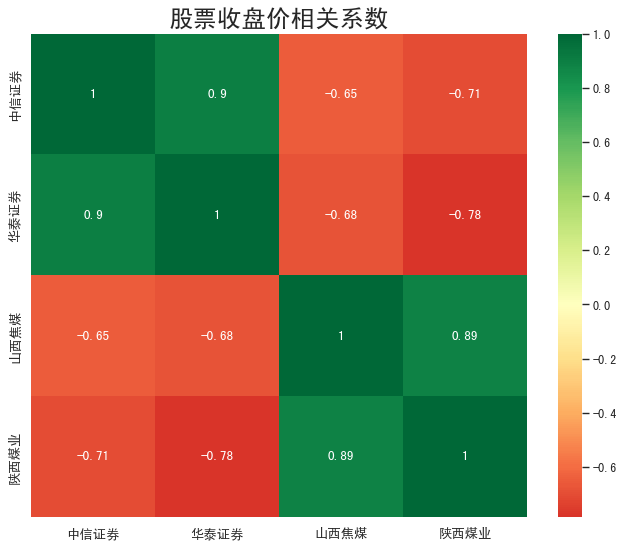

In [6]:
price=pd.DataFrame([zxzq_p,htzq_p,sxjm_p,sxmy_p]).T
price.columns=['中信证券','华泰证券','山西焦煤','陕西煤业']

# Heatmap plot
plt.figure(figsize = (10,8),dpi = 80)
sns.heatmap(price.corr(),xticklabels = price.corr().columns, yticklabels = price.corr().columns,
            cmap = "RdYlGn",center = 0, annot = True)

# Decoration
plt.title('股票收盘价相关系数',fontsize = 22)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

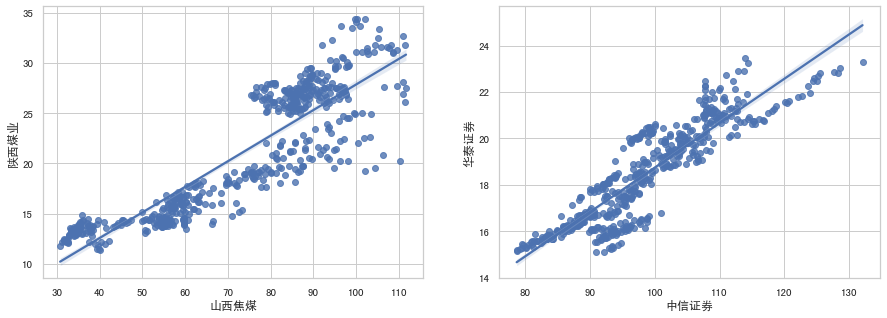

In [9]:
#散点
#yfyf_p,lyjt_p,zxzq_p,htzq_p,sxjm_p,sxmy_p
plt.figure(figsize = (15,5))
plt.title('股票相关性对比',fontsize = 22)
a1 = plt.subplot(121)
sns.regplot(x=sxjm_p,y=sxmy_p)
plt.xlabel('山西焦煤')
plt.ylabel('陕西煤业')
a2 = plt.subplot(122)
sns.regplot(x=zxzq_p,y=htzq_p)
plt.xlabel('中信证券')
plt.ylabel('华泰证券')
plt.show()

In [171]:
#回归预测策略回测，建立线性回归模型，估计均衡时的系数
import statsmodels.api as sm
def backtest(A,B,A_name,B_name):
    x = A[:243]
    y = B[:243]
    model = sm.OLS(y, sm.add_constant(x)).fit()
    alpha = model.params[0]
    beta = model.params[1]
    print('alpha:', alpha)
    print('beta:', beta)

    resid = y - alpha - beta * x
    std = resid.std()
    mean = resid.mean()
    print('残差标准差：', std)
    print('残差均值：', mean)
    
    x = A[243:]
    y = B[243:]
    resid = y - alpha - beta * x
    # 设定开仓和平仓的阈值，这里以标准差的倍数为例
    open_num = 2 # 开仓阈值，超过均值1.5个标准差时开仓
    close_num = 1.5 # 平仓阈值，低于均值0.5个标准差时平仓

    # 根据残差序列判断交易信号，并记录每日持仓情况和收益情况
    position = 0 # 初始持仓为0，表示空仓；持仓为1表示做多x做空y；持仓为-1表示做空x做多y。
    capital = 1000000 # 初始资金为100万
    fee_rate = 0.0005 # 手续费率为万分之五
    trade_log = [] # 记录交易日志
    for i in range(len(resid)-1):
        if position == 0: # 空仓状态下判断是否开仓
            if resid[i] < mean - open_num * std: # 残差小于下限，做空x做多y
                
                position = -1 # 持仓变为-1
                
                x_price = x[i] * (1 - fee_rate) # 计算买入x的价格（考虑手续费）
                y_price = y[i] * (1 + fee_rate) # 计算卖出y的价格（考虑手续费）
                
                x_amount = capital / 2 / x_price # 计算卖出x
                y_amount = capital / 2 / y_price # 计算买入y的数量
                
                trade_log.append([time[i+243], '开仓', -1, x_price, y_price, x_amount, y_amount]) # 记录交易日志
                
            elif resid[i] > mean + open_num * std: # 残差大于上限，做多x做空y
                
                position = 1 # 持仓变为1
                #买x卖y(多买x少买y)
                x_price = x[i] * (1 + fee_rate) # 计算买入x的价格（考虑手续费）
                y_price = y[i] * (1 - fee_rate) # 计算卖出y的价格（考虑手续费）
                
                x_amount = capital / 2 / x_price # 计算卖出x的数量
                y_amount = capital / 2 / y_price # 计算买入y的数量
                
                trade_log.append([time[i+243], '开仓', 1, x_price, y_price, x_amount, y_amount]) # 记录交易日志
        
        elif position == -1: # 做空x做多y状态下判断是否平仓
            #卖y还x(y高x低)y会跌x会涨
            if resid[i] > mean - close_num * std: # 残差大于平仓阈值，平仓
                position = 0 # 持仓变为0
                x_price = x[i] * (1 + fee_rate) # 计算卖出x的价格（考虑手续费）
                y_price = y[i] * (1 - fee_rate) # 计算买入y的价格（考虑手续费）
                
                trade_log.append([time[i+243], '平仓', 0, x_price, y_price]) # 记录交易日志
        
        elif position == 1: # 做多x做空y状态下判断是否平仓
            #卖x还y x高价
            if resid[i] < mean + close_num * std: # 残差小于平仓阈值，平仓
                
                position = 0 # 持仓变为0
                
                x_price = x[i] * (1 - fee_rate) # 计算买入x的价格（考虑手续费）
                y_price = y[i] * (1 + fee_rate) # 计算卖出y的价格（考虑手续费）
                
                trade_log.append([time[i+243], '平仓', 0, x_price,y_price]) # 记录交易日志

    if position == -1: # 做空x做多y状态下判断是否平仓
        #卖y还x(y高x低)y会跌x会涨
        position = 0 # 持仓变为0
        x_price = x[i] * (1 + fee_rate) # 计算卖出x的价格（考虑手续费）
        y_price = y[i] * (1 - fee_rate) # 计算买入y的价格（考虑手续费）
        trade_log.append([time[i+243], '平仓', 0, x_price, y_price]) # 记录交易日志
    elif position == 1: # 做多x做空y状态下判断是否平仓
        #卖x还y x高价
        position = 0 # 持仓变为0
        x_price = x[i] * (1 - fee_rate) # 计算买入x的价格（考虑手续费）
        y_price = y[i] * (1 + fee_rate) # 计算卖出y的价格（考虑手续费）
        trade_log.append([time[i+243], '平仓', 0, x_price,y_price]) # 记录交易日志
    # 将交易日志转换为DataFrame格式，并计算每次交易的收益和累计收益
    trade_log = pd.DataFrame(trade_log, columns=['日期', '操作', '持仓', f'价格_{A_name}', f'价格_{B_name}', f'持仓_{A_name}', f'持仓_{B_name}'])
    plt.figure(figsize = (15,5))
    sns.lineplot(x=time[243:],y=x)
    sns.lineplot(x=time[243:],y=y)
    sns.scatterplot(x=trade_log[trade_log['持仓']==1]['日期'],y=trade_log[trade_log['持仓']==1][f'价格_{A_name}'],s=100,color='red')
    sns.scatterplot(x=trade_log[trade_log['持仓']==1]['日期'],y=trade_log[trade_log['持仓']==1][f'价格_{B_name}'],s=100,color='green')
    sns.scatterplot(x=trade_log[trade_log['持仓']==0]['日期'],y=trade_log[trade_log['持仓']==0][f'价格_{A_name}'],s=100,color='black')
    sns.scatterplot(x=trade_log[trade_log['持仓']==0]['日期'],y=trade_log[trade_log['持仓']==0][f'价格_{B_name}'],s=100,color='black')
    sns.scatterplot(x=trade_log[trade_log['持仓']==-1]['日期'],y=trade_log[trade_log['持仓']==-1][f'价格_{A_name}'],s=100,color='green')
    sns.scatterplot(x=trade_log[trade_log['持仓']==-1]['日期'],y=trade_log[trade_log['持仓']==-1][f'价格_{B_name}'],s=100,color='red')
    plt.legend([A_name,B_name,'做多','做空','平仓'],loc='upper right',fontsize=16)
    plt.ylabel('收盘价')
    plt.title('策略操作',fontsize = 22)
    plt.show()
    trade_log['收益'] = 0
    trade_log['累计收益'] = 0
    for i in range(1, len(trade_log)):
        if trade_log.loc[i, '操作'] == '平仓':
            if trade_log.loc[i-1, '持仓'] == 1:#x涨价
                trade_log.loc[i, '收益'] = ( trade_log.loc[i, f'价格_{A_name}']- trade_log.loc[i-1, f'价格_{A_name}'] ) * trade_log.loc[i-1, f'持仓_{A_name}']+ (trade_log.loc[i-1, f'价格_{B_name}']- trade_log.loc[i, f'价格_{B_name}'] ) * trade_log.loc[i-1, f'持仓_{B_name}']
            elif trade_log.loc[i-1, '持仓'] == -1:
                trade_log.loc[i, '收益'] = ( trade_log.loc[i-1, f'价格_{A_name}']- trade_log.loc[i, f'价格_{A_name}'] ) * trade_log.loc[i-1, f'持仓_{A_name}']+ (trade_log.loc[i, f'价格_{B_name}']- trade_log.loc[i-1, f'价格_{B_name}'] ) * trade_log.loc[i-1, f'持仓_{B_name}']
            trade_log.loc[i, '累计收益'] = trade_log.loc[i-1, '累计收益'] + trade_log.loc[i, '收益']
        else:
            trade_log.loc[i, '累计收益'] = trade_log.loc[i-1, '累计收益']
    # 打印交易日志
    return trade_log

alpha: 8.98905566149817
beta: 0.11109551035328988
残差标准差： 0.9762181873371236
残差均值： 7.734096856318787e-15


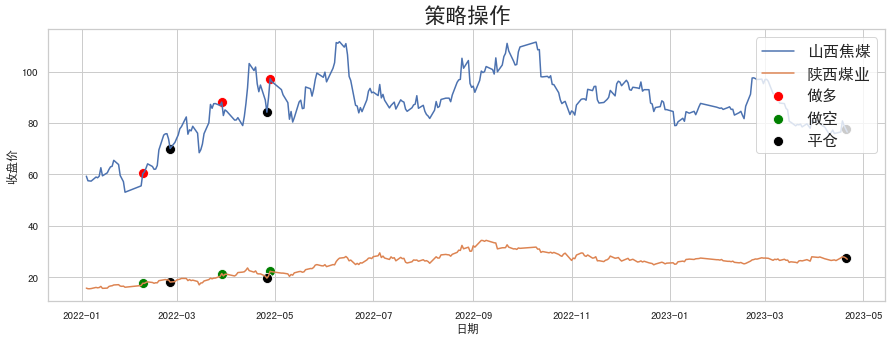

,日期,操作,持仓,价格_山西焦煤,价格_陕西煤业,持仓_山西焦煤,持仓_陕西煤业,收益,累计收益
0,2022-02-08,开仓,1,60.403387,17.724933,8277.681570,28208.851180,0.000000,0.000000
1,2022-02-25,平仓,0,70.069148,18.181386,NaN,NaN,67134.078011,67134.078011
2,2022-03-29,开仓,1,88.171063,21.489050,5670.794705,23267.664121,0.000000,67134.078011
3,2022-04-26,平仓,0,84.178790,19.729760,NaN,NaN,18295.206326,85429.284337
4,2022-04-28,开仓,1,97.289921,22.378505,5139.278526,22342.868599,0.000000,85429.284337
5,2023-04-20,平仓,0,77.789286,27.610398,NaN,NaN,-217114.694588,-131685.410251


In [210]:
#陕西煤业+山西焦煤进行回测
sxjm_sxmy = backtest(sxjm_p,sxmy_p,'山西焦煤','陕西煤业')
sxjm_sxmy

alpha: 6.3940200472549105
beta: 0.12973315243979477
残差标准差： 0.7763336451517665
残差均值： -8.201943925132021e-15


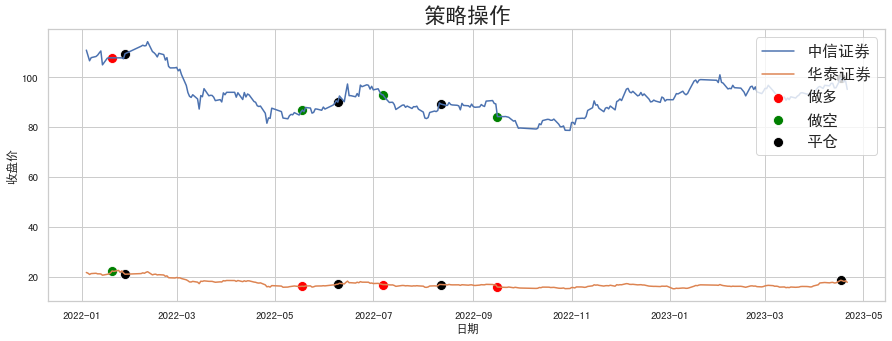

,日期,操作,持仓,价格_中信证券,价格_华泰证券,持仓_中信证券,持仓_华泰证券,收益,累计收益
0,2022-01-20,开仓,1,107.798873,22.241973,4638.267436,22480.019641,0.000000,0.000000
1,2022-01-28,平仓,0,109.338903,20.940165,NaN,NaN,36407.757143,36407.757143
2,2022-05-18,开仓,-1,86.759998,16.109651,5763.024548,31037.295979,0.000000,36407.757143
3,2022-06-09,平仓,0,90.005680,16.914239,NaN,NaN,6267.285912,42675.043055
4,2022-07-07,开仓,-1,92.849152,16.771782,5385.078788,29811.978771,0.000000,42675.043055
5,2022-08-12,平仓,0,89.249302,16.801495,NaN,NaN,20271.288827,62946.331882
6,2022-09-16,开仓,-1,84.130414,15.763978,5943.153941,31717.882277,0.000000,62946.331882
7,2023-04-17,平仓,0,99.576263,18.489251,NaN,NaN,-5357.182651,57589.149231


In [211]:
### 中信证券+华泰证券进行回测
zxzq_htzq = backtest(zxzq_p,htzq_p,'中信证券','华泰证券')
zxzq_htzq

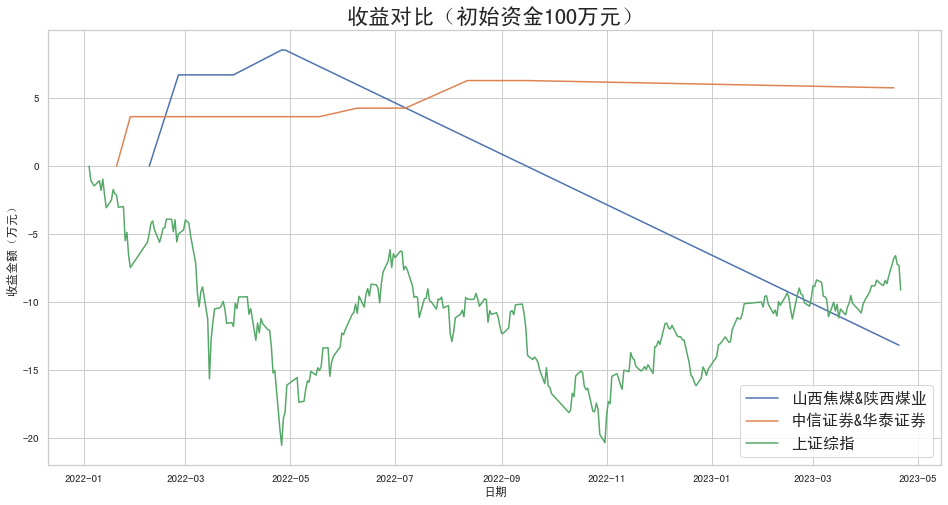

山西焦煤&陕西煤业协整性检验p值：0.26524187103763663
中信证券&华泰证券协整性检验p值：0.05749566439056614


In [243]:
investment_return = szzz.iloc[243:][['time','close']]
price_0=investment_return.iloc[0,1]
volume_0=1000000/price_0
investment_return['close'] = (investment_return['close']*volume_0-1000000)/10000

plt.figure(figsize = (16,8))
sns.lineplot(x=sxjm_sxmy['日期'],y=sxjm_sxmy['累计收益']/10000)
sns.lineplot(x=zxzq_htzq['日期'],y=zxzq_htzq['累计收益']/10000)
sns.lineplot(x=time[243:],y=investment_return['close'])
plt.legend(['山西焦煤&陕西煤业','中信证券&华泰证券','上证综指'],loc='lower right',fontsize=16)
plt.ylabel('收益金额（万元）')
plt.title('收益对比（初始资金100万元）',fontsize = 22)
plt.show()
coint_test = sm.tsa.stattools.coint(sxjm_p,sxmy_p)[1]
print("山西焦煤&陕西煤业协整性检验p值："+ str(coint_test))
coint_test = sm.tsa.stattools.coint(zxzq_p,htzq_p)[1]
print("中信证券&华泰证券协整性检验p值："+ str(coint_test))

In [223]:
sxmy['month'] = sxmy['time'].apply(lambda x:str(x)[:7])
sxmy_monthly = sxmy.groupby('month').first().reset_index()
sxjm['month'] = sxjm['time'].apply(lambda x:str(x)[:7])
sxjm_monthly = sxjm.groupby('month').first().reset_index()
zxzq['month'] = zxzq['time'].apply(lambda x:str(x)[:7])
zxzq_monthly = zxzq.groupby('month').first().reset_index()
htzq['month'] = htzq['time'].apply(lambda x:str(x)[:7])
htzq_monthly = htzq.groupby('month').first().reset_index()
htzq_monthly.head(5)

,month,number,time,thscode,open,high,low,close,volume,amount,turnoverRatio,totalCapital,pe,pb
0,2021-01,1674,2021-01-04,601688.SH,21.6772,21.7010,21.1883,21.5102,100019893.0,1.802526e+09,1.3594,1.506271e+11,15.1299,1.2686
1,2021-02,1654,2021-02-01,601688.SH,20.6517,20.8306,20.4252,20.7829,54356852.0,9.429094e+08,0.7388,1.460387e+11,14.6183,1.2257
2,2021-03,1639,2021-03-01,601688.SH,20.4967,20.5683,20.2225,20.3536,56004294.0,9.552994e+08,0.7612,1.420979e+11,14.3163,1.2004
3,2021-04,1616,2021-04-01,601688.SH,20.2463,20.3536,20.1629,20.3179,29060843.0,4.936575e+08,0.3950,1.427775e+11,11.6852,1.1717
4,2021-05,1595,2021-05-06,601688.SH,19.0540,19.2447,18.8870,18.8990,35701161.0,5.712284e+08,0.4882,1.324696e+11,10.8691,1.0899


Text(0.5, 1.0, '投资组合的平均总市值')

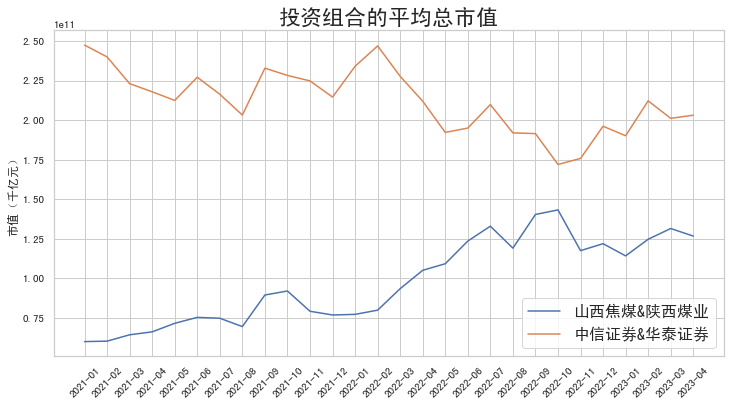

In [233]:
#小市值组合
plt.figure(figsize = (12,6))
sns.lineplot(x=sxmy_monthly.month,y=(sxmy_monthly.totalCapital.to_numpy() + sxjm_monthly.totalCapital.to_numpy())/2)
sns.lineplot(x=zxzq_monthly.month,y=(zxzq_monthly.totalCapital.to_numpy() + htzq_monthly.totalCapital.to_numpy())/2)
plt.legend(['山西焦煤&陕西煤业','中信证券&华泰证券'],loc='lower right',fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('市值（千亿元）')
plt.xlabel('')
plt.title("投资组合的平均总市值",fontsize=22)

Text(0.5, 1.0, '投资组合的平均换手率')

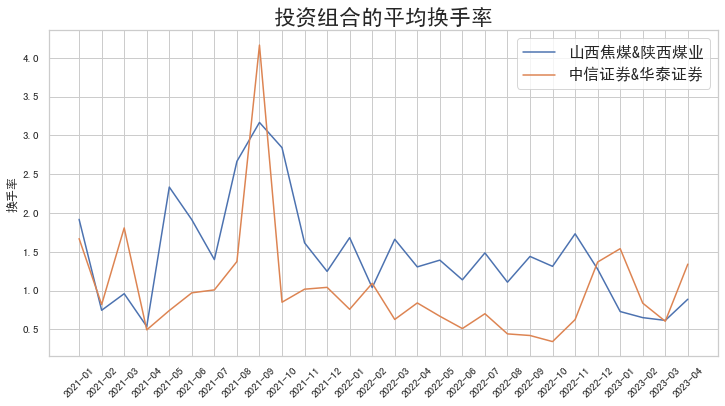

In [236]:
#高流动性组合
plt.figure(figsize = (12,6))
sns.lineplot(x=sxmy_monthly.month,y=(sxmy_monthly.turnoverRatio.to_numpy() + sxjm_monthly.turnoverRatio.to_numpy())/2)
sns.lineplot(x=zxzq_monthly.month,y=(zxzq_monthly.turnoverRatio.to_numpy() + htzq_monthly.turnoverRatio.to_numpy())/2)
plt.legend(['山西焦煤&陕西煤业','中信证券&华泰证券'],loc='upper right',fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('换手率')
plt.xlabel('')
plt.title("投资组合的平均换手率",fontsize=22)

Text(0.5, 1.0, '投资组合的平均市盈率')

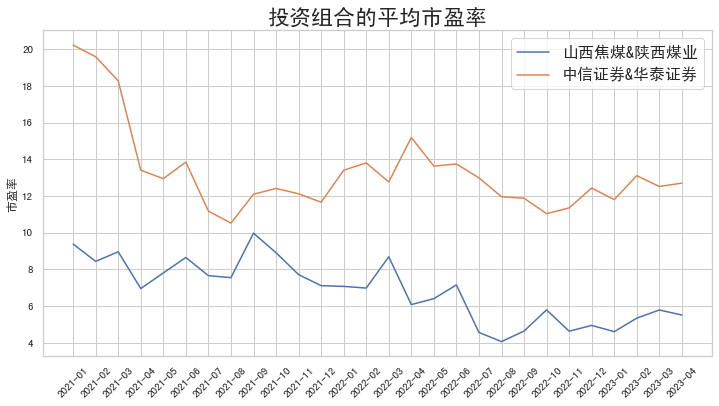

In [238]:
#低市盈率组合，说明投资回收期短，投资风险小
plt.figure(figsize = (12,6))
sns.lineplot(x=sxmy_monthly.month,y=(sxmy_monthly.pe.to_numpy() + sxjm_monthly.pe.to_numpy())/2)
sns.lineplot(x=zxzq_monthly.month,y=(zxzq_monthly.pe.to_numpy() + htzq_monthly.pe.to_numpy())/2)
plt.legend(['山西焦煤&陕西煤业','中信证券&华泰证券'],loc='upper right',fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('市盈率')
plt.xlabel('')
plt.title("投资组合的平均市盈率",fontsize=22)

Text(0.5, 1.0, '投资组合的平均市净率')

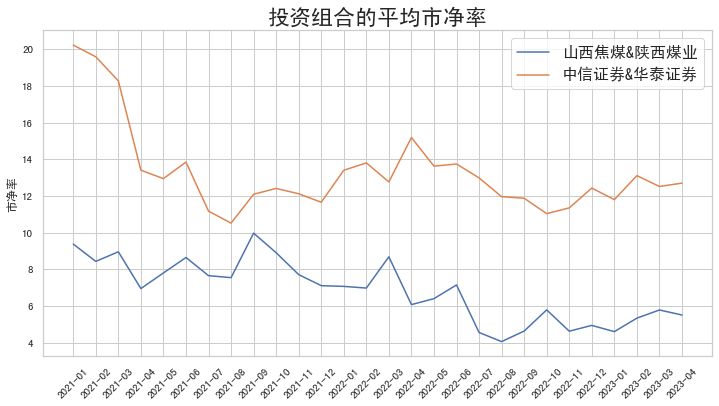

In [239]:
#PB值大于1,说明股权价值高于账面净资产
plt.figure(figsize = (12,6))
sns.lineplot(x=sxmy_monthly.month,y=(sxmy_monthly.pe.to_numpy() + sxjm_monthly.pe.to_numpy())/2)
sns.lineplot(x=zxzq_monthly.month,y=(zxzq_monthly.pe.to_numpy() + htzq_monthly.pe.to_numpy())/2)
plt.legend(['山西焦煤&陕西煤业','中信证券&华泰证券'],loc='upper right',fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('市净率')
plt.xlabel('')
plt.title("投资组合的平均市净率",fontsize=22)